# Install

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %pip install git+https://github.com/friedrichknuth/gtsa.git

In [ ]:
# need to rerun everytime restart
! pip install tools

In [ ]:
# ! pip install

In [67]:
# !pip install -q condacolab

In [ ]:
conda install mamba -n base -c conda-forge

In [1]:
! git clone https://github.com/friedrichknuth/gtsa.git

fatal: destination path 'gtsa' already exists and is not an empty directory.


In [7]:
! pwd

/home/jovyan/geosmart_hackweek/space_time


In [ ]:
# takes about 4 min, need to rerun everytime restart
%cd ./gtsa
! mamba env create -f environment.yml
! conda activate gtsa
! pip install -e .

# Import data

In [3]:
import xarray as xr
import tools
import pandas as pd
import numpy as np
import gtsa
import matplotlib.pyplot as plt

In [3]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True}, decode_times=False)
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True}, decode_times=False)

units, reference_date = baker_ds.time.attrs['units'].split('since')
baker_ds['time'] = pd.date_range(start=reference_date, periods=baker_ds.sizes['time'], freq='MS')

In [5]:
baker_ds.chunk("auto", balance=True)['band1']

<xarray.DataArray 'band1' (time: 55, y: 12089, x: 11383)>
dask.array<open_dataset-band1, shape=(55, 12089, 11383), dtype=float32, chunksize=(55, 712, 670), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1947-10-01 1947-11-01 ... 1952-04-01
  * x        (x) float64 5.809e+05 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y        (y) float64 5.409e+06 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Downscale or subset data set

In [19]:
# small_baker_ds = baker_ds
# small_baker_ds=small_baker_ds.coarsen(x=150,y=150,time=5,boundary='trim').mean()

In [4]:
# if it says gtsa.geospatial not found, just restart and try again
small_baker_ds = gtsa.geospatial.extract_dataset_center_window(baker_ds, size = 200)

Dataset center: 586638.4387119232, 5403404.566348841
Test column size: 200.0 by 200.0 in spatial coordinate units.
No CRS defined.
Using xarray slicing to select data along spatial coordinate axes.


/home/jovyan/geosmart_hackweek/space_time/gtsa/gtsa/geospatial.py:78: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  xmode = np.abs(scipy.stats.mode(ds["y"].diff("y"))[0])
/home/jovyan/geosmart_hackweek/space_time/gtsa/gtsa/geospatial.py:79: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

In [7]:
small_baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 201, x: 201)
Coordinates:
  * time         (time) datetime64[ns] 1947-10-01 1947-11-01 ... 1952-04-01
  * x            (x) float64 5.865e+05 5.865e+05 ... 5.867e+05 5.867e+05
  * y            (y) float64 5.404e+06 5.404e+06 ... 5.403e+06 5.403e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 201, 201), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

# Reproduce temporal GP in gsta

## Start Dask dashboard

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42061")
client

## Generate time and space to predict

In [15]:
import numpy as np

# create a time series to make predictions on as decimal year floats
# It is the same year just in a float data type??
start = small_baker_ds['time'].dt.strftime('%Y-%m-%d').values[0]
end = small_baker_ds['time'].dt.strftime('%Y-%m-%d').values[-1]
prediction_time_series = gtsa.temporal.create_prediction_timeseries(start_date = start,
                                                                    end_date = end,
                                                                    dt ='Y')

# prepare time values as decimal year floats
times = [pd.to_datetime(j) for j in small_baker_ds['band1'].time.values]
decyear_times = [gtsa.utils.date_time_to_decyear(i) for i in times] 
decyear_times = np.array(decyear_times)

small_baker_ds_train = small_baker_ds
small_baker_ds_train['time'] = decyear_times

NameError: name 'small_baker_ds' is not defined

In [8]:
xmin = small_baker_ds['band1'].x.values.min()
xmax = small_baker_ds['band1'].x.values.max()
ymin = small_baker_ds['band1'].y.values.min()
ymax = small_baker_ds['band1'].y.values.max()
nx,ny = len(small_baker_ds['band1'].x.values),len(small_baker_ds['band1'].y.values)

prediction_x,prediction_y = gtsa.temporal.EL_create_prediction_space(xmin,xmax,ymin,ymax,
                                                                     int(1.5*nx),int(1.5*ny))
prediction_X,prediction_Y = np.meshgrid(prediction_x,prediction_y)
prediction_xy = np.array([prediction_x,prediction_y]).T

## Linear Reg

In [55]:
def custom_linreg(x,y, threshold = 2):
    mask = np.isfinite(y) # create mask for np.nan values
    if len(y[mask]) < threshold: # return np.nan if less than threshold
        return np.nan
    return np.polyfit(x[mask], y[mask], 1)[0]

In [56]:
print(small_baker_ds_train)

<xarray.Dataset>
Dimensions:      (time: 55, y: 101, x: 101)
Coordinates:
  * time         (time) float64 1.948e+03 1.948e+03 ... 1.952e+03 1.952e+03
  * x            (x) float64 5.866e+05 5.866e+05 ... 5.867e+05 5.867e+05
  * y            (y) float64 5.403e+06 5.403e+06 ... 5.403e+06 5.403e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 101, 101), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0


In [57]:
result = xr.apply_ufunc(
        custom_linreg, decyear_times , small_baker_ds_train['band1'],
        input_core_dims=[['time'], ['time']],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )

In [58]:
custom_slope = result.compute()

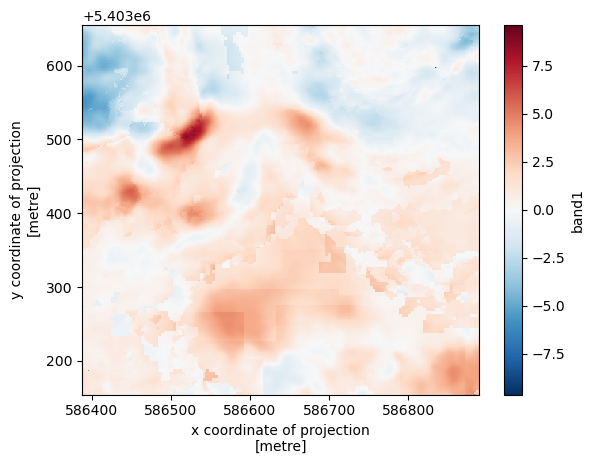

In [33]:
custom_slope.plot()

## Temporal GP

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    PairwiseKernel,
    RationalQuadratic,
    WhiteKernel,
    Matern,
)

In [8]:
k1 = 30.0 * Matern(length_scale=10.0, nu=1.5)
k2 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=30)
k3 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=1)

kernel = k1+k2+k3

In [ ]:
ds_result = gtsa.temporal.dask_apply_GPR(small_baker_ds_train['band1'],
                                         'time', 
                                         kwargs={'times':small_baker_ds['band1'].time.values,
                                                 'kernel': kernel,
                                                 'prediction_time_series' : prediction_time_series}
                                        ).compute()

In [27]:
prediction_time_series

array([1947.99657769, 1948.99726776, 1949.99657769, 1950.99657769,
       1951.99657769])

# Implementation of space GP (under dev)

## Generate synthetic data

In [3]:
import numpy as np
size_z = 10
size_y = 10
size_x = 10

In [4]:
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise):
    z = np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return z + np.random.normal(size=z.shape) * noise

In [5]:
def make_test_dataset(size_z, size_y, size_x, x0, y0, sigma_x, sigma_y, noise):
    x = np.linspace(-3, 3, size_x)
    y = np.linspace(-3, 3, size_y)

    X,Y = np.meshgrid(x, y)

    z = np.zeros((size_z,size_y,size_x))

    # Factor to vary maxima of Gaussian
    z_range = np.linspace(-5, 5, size_z)
    
    for i in range(size_z):
        z[i] = gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise) * np.exp(-(z_range[i] ** 2) / 2)
    
    # manually add some nans
    z[0,1],z[0,2],z[0,3]=np.nan,np.nan,np.nan
    return x, y, z

In [6]:
# Generate the dimensions and vectors, z will be our 'DEMs'
x, y, z = make_test_dataset(size_z, size_y, size_x, 0, 0, 1, 1, 0.05)
xy = np.array([x,y]).T
X,Y = np.meshgrid(x,y)

In [7]:
print("size of x ", x.shape, ", type of x ",type(x))
print("size of y ", y.shape, ", type of y ",type(y))
print("size of z ", z.shape, ", type of z ",type(z))

size of x  (10,) , type of x  <class 'numpy.ndarray'>
size of y  (10,) , type of y  <class 'numpy.ndarray'>
size of z  (10, 10, 10) , type of z  <class 'numpy.ndarray'>


## Generate space to predict

In [8]:
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
nx,ny = len(x),len(y)
nx_predict,ny_predict = 2*len(x),2*len(y)

prediction_x,prediction_y = gtsa.temporal.EL_create_prediction_space(xmin,xmax,ymin,ymax,
                                                                     nx_predict,ny_predict)
prediction_X,prediction_Y = np.meshgrid(prediction_x,prediction_y)
prediction_xy = np.array([prediction_x,prediction_y]).T
print("size of x predict ", prediction_x.shape)
print("size of y predict ", prediction_y.shape)
print("size of xy predict ", prediction_xy.shape)

size of x predict  (20,)
size of y predict  (20,)
size of xy predict  (20, 2)


## Select kenerl

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    PairwiseKernel,
    RationalQuadratic,
    WhiteKernel,
    Matern,
)

In [16]:
# may need to param tuning

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
k1 = 1.0 * Matern(length_scale=0.5, nu=1.0)
# k2 = ConstantKernel(1) * ExpSineSquared(length_scale=10, periodicity=30)
# k3 = ConstantKernel(1) * ExpSineSquared(length_scale=10, periodicity=30)

kernel = k1#+k2+k3

## Tidy up input data

In [11]:
# currently only testing one slice in time
z_array = z[:,:,0]
mask = np.isfinite(z_array)
X,Y = np.meshgrid(x,y)
z_array = z_array[mask] 
x_array = X[mask]    
y_array = Y[mask]
xy_array = np.array([y_array,x_array]).T
print("shape of input x ", x_array.shape)
print("shape of input y ", y_array.shape)
print("shape of input xz ", xy_array.shape)
print("shape of input z ", z_array.shape)

shape of input x  (97,)
shape of input y  (97,)
shape of input xz  (97, 2)
shape of input z  (97,)


## Run spatial GP in gtsa

In [17]:
# test EL_GPR_model
model = gtsa.temporal.EL_GPR_model(xy_array,z_array,kernel,alpha=50)

1**2 * Matern(length_scale=0.5, nu=1)
(97,)


In [18]:
from itertools import product
xy_predict = np.array(list(product(prediction_x,prediction_y)))
print("shape of input xy_predict ", xy_predict.shape)
print("shape of input x_predict ", prediction_x.shape)
mean_prediction, std_prediction = gtsa.temporal.EL_GPR_predict(model, xy_predict)
print("shape of mean_predict ", mean_prediction.shape)
print("shape of std_prediction ", std_prediction.shape)

shape of input xy_predict  (400, 2)
shape of input x_predict  (20,)
shape of mean_predict  (400,)
shape of std_prediction  (400,)


## Visualization of output slice

In [19]:
mean_prediction=mean_prediction.reshape(nx_predict,ny_predict)
std_prediction=std_prediction.reshape(nx_predict,ny_predict)
print(mean_prediction.shape)

(20, 20)


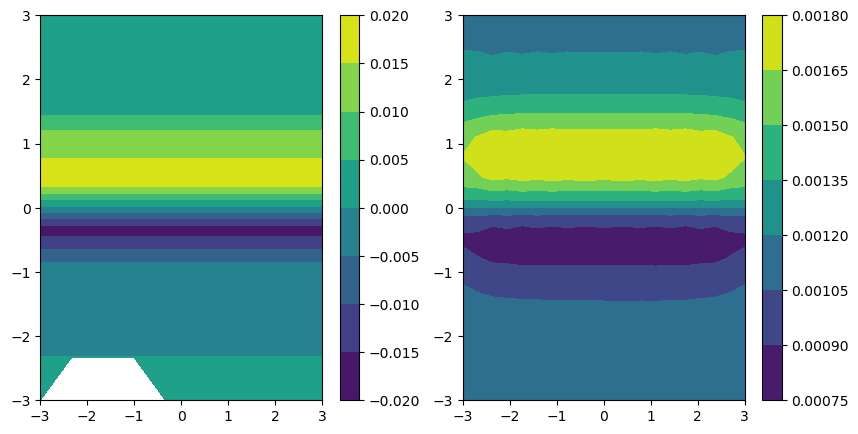

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

# create the figure
fig = plt.figure(figsize=(10,5))

# show the 3D rotated projection
ax2 = fig.add_subplot(121)
cset = plt.contourf(X,Y, z[:,:,0], cmap='viridis')
plt.colorbar()
ax2 = fig.add_subplot(122)
cset = plt.contourf(prediction_X,prediction_Y, mean_prediction, cmap='viridis')
plt.colorbar()

plt.show()

# Try Baker's data on spatial GP in gtsa

## Subset data

In [4]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True}, decode_times=False)
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True}, decode_times=False)

units, reference_date = baker_ds.time.attrs['units'].split('since')
baker_ds['time'] = pd.date_range(start=reference_date, periods=baker_ds.sizes['time'], freq='MS')

In [5]:
# if it says gtsa.geospatial not found, just restart and try again
subset_size = 50
small_baker_ds = gtsa.geospatial.extract_dataset_center_window(baker_ds, size = subset_size)

Dataset center: 586638.4387119232, 5403404.566348841
Test column size: 50.0 by 50.0 in spatial coordinate units.
No CRS defined.
Using xarray slicing to select data along spatial coordinate axes.


/home/jovyan/geosmart_hackweek/space_time/gtsa/gtsa/geospatial.py:78: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  xmode = np.abs(scipy.stats.mode(ds["y"].diff("y"))[0])
/home/jovyan/geosmart_hackweek/space_time/gtsa/gtsa/geospatial.py:79: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to

## Generate new space to predict

In [6]:
xmin = small_baker_ds['band1'].x.values.min()
xmax = small_baker_ds['band1'].x.values.max()
ymin = small_baker_ds['band1'].y.values.min()
ymax = small_baker_ds['band1'].y.values.max()
nx,ny = len(small_baker_ds['band1'].x.values),len(small_baker_ds['band1'].y.values)
nx_predict,ny_predict = 2*(nx),2*(ny)

prediction_x,prediction_y = gtsa.temporal.EL_create_prediction_space(xmin,xmax,ymin,ymax,
                                                                     nx_predict,ny_predict)
prediction_X,prediction_Y = np.meshgrid(prediction_x,prediction_y)
prediction_xy = np.array([prediction_y,prediction_x]).T

In [7]:
small_baker_ds['band1'].values.shape

(55, 51, 51)

## Select Kernel

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    PairwiseKernel,
    RationalQuadratic,
    WhiteKernel,
    Matern,
)

In [48]:
# may need to param tuning

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1e-3, nu=1.0)
length_scale_param=1.9
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5
matern=Matern(length_scale=length_scale_param,
              length_scale_bounds=length_scale_bounds_param,nu=nu_param)
kernel = matern + WhiteKernel()

# kernel = k1
# kernel = k1+k2+k3

## Tidy up input data

In [10]:
print(small_baker_ds['band1'].values.shape)
print(small_baker_ds['band1'].x.values.shape)
print(small_baker_ds['band1'].y.values.shape)

(55, 51, 51)
(51,)
(51,)


In [11]:
# currently only testing one slice in time
z_array_nomask = small_baker_ds['band1'].values[50,:,:]
X,Y = np.meshgrid(small_baker_ds['band1'].x.values,small_baker_ds['band1'].y.values)

mask = np.isfinite(z_array_nomask)
# print(z_array_nomask)
z_array = z_array_nomask[mask] 
x_array = X[mask]    
y_array = Y[mask]
xy_array = np.array([y_array,x_array]).T
print("shape of input x ", x_array.shape)
print("shape of input y ", y_array.shape)
print("shape of input xz ", xy_array.shape)
print("shape of input z ", z_array.shape)

shape of input x  (2601,)
shape of input y  (2601,)
shape of input xz  (2601, 2)
shape of input z  (2601,)


## Run spatial GP in gtsa

In [27]:
print(z_array.min())

3231.3748


In [49]:
# test EL_GPR_model
model = gtsa.temporal.EL_GPR_model(xy_array,z_array,kernel,alpha=5)

Matern(length_scale=1.9, nu=2.5) + WhiteKernel(noise_level=1)
(2601,)


In [50]:
from itertools import product
xy_predict = np.array(list(product(prediction_x,prediction_y)))
print("shape of input xy_predict ", xy_predict.shape)
print("shape of input x_predict ", prediction_x.shape)
mean_prediction, std_prediction = gtsa.temporal.EL_GPR_predict(model, xy_predict)
print("shape of mean_predict ", mean_prediction.shape)
print("shape of std_prediction ", std_prediction.shape)

shape of input xy_predict  (10404, 2)
shape of input x_predict  (102,)
shape of mean_predict  (10404,)
shape of std_prediction  (10404,)


## Visualization of output slice

In [51]:
mean_prediction=mean_prediction.reshape(nx_predict,ny_predict)
std_prediction=std_prediction.reshape(nx_predict,ny_predict)
print(mean_prediction)

[[3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]
 [3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]
 [3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]
 ...
 [3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]
 [3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]
 [3244.92724609 3244.92724609 3244.92724609 ... 3244.92724609
  3244.92724609 3244.92724609]]


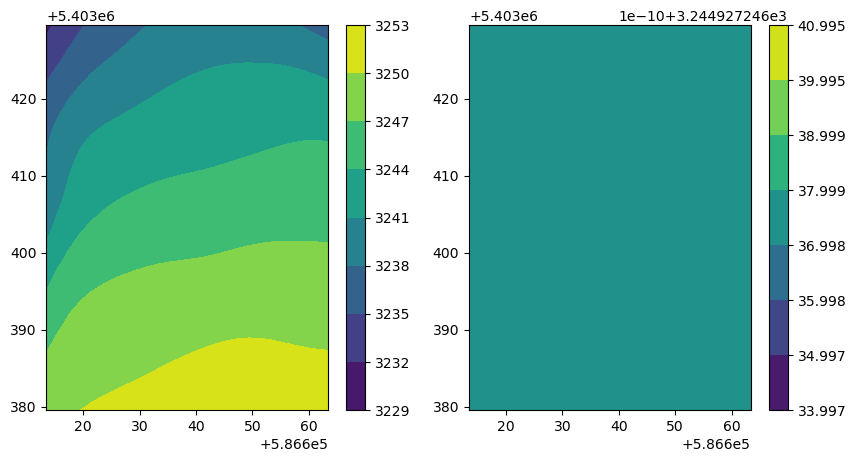

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

# create the figure
fig = plt.figure(figsize=(10,5))

# show the 3D rotated projection
ax2 = fig.add_subplot(121)
cset = plt.contourf(X,Y, z_array_nomask, cmap='viridis')
plt.colorbar()
ax2 = fig.add_subplot(122)
cset = plt.contourf(prediction_X,prediction_Y, mean_prediction, cmap='viridis')
plt.colorbar()

plt.show()

# Ignore below

In [11]:
ds_result = gtsa.temporal.EL_dask_apply_GPR(small_baker_ds_train['band1'],
                                         [['y','x']], 
                                         kwargs={'x':small_baker_ds['band1'].x.values,
                                                 'y':small_baker_ds['band1'].y.values,
                                                 'kernel': kernel,
                                                 'prediction_x' : prediction_X,
                                                 'prediction_y' : prediction_Y,
                                                 'prediction_xy' : prediction_xy}
                                        ).compute()

/home/jovyan/geosmart_hackweek/space_time/gtsa/gtsa/temporal.py:193: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  results = xr.apply_ufunc(


KilledWorker: Attempted to run task ('vectorize_EL_dask_GPR-cd8cb23de5827c5d4240fb012a6a4c9e', 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:40417. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [23]:
print((small_baker_ds_train['band1'].shape))
small_baker_ds_train['band1']=small_baker_ds_train['band1'].transpose("x","y","time")
print((small_baker_ds_train['band1'].shape))

(101, 101, 55)
(101, 101, 55)


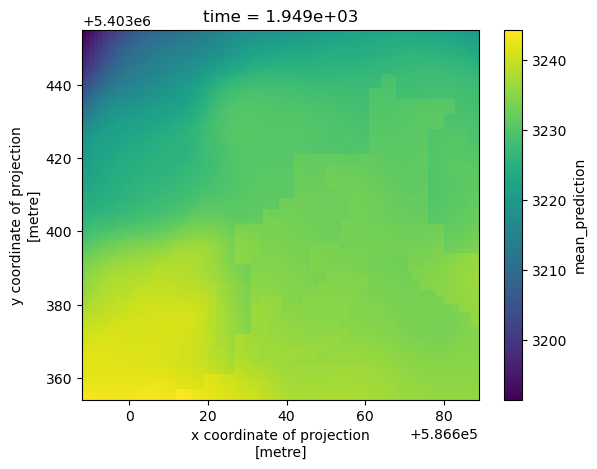

In [65]:
ds_result['mean_prediction'].isel(time=1).plot();

# Visualization of 3D data

In [258]:
data = small_baker_ds_train['band1'].to_numpy()
size_data = data.shape
data_toplot = np.zeros((size_data[1],size_data[2],size_data[0]))
for i in range(size_data[0]):
    data_toplot[:,:,i]=data[i,:,:]
# data_toplot=data_toplot.reshape(size_data[1],size_data[2],size_data[0])
data_toplot.shape
mask = ~np.isnan(data_toplot)

In [23]:
time = small_baker_ds_train['band1'].time.values

array([1947.74743326, 1947.83230664, 1947.91444216, 1948.        ,
       1948.08469945, 1948.16393443, 1948.24863388, 1948.33060109,
       1948.41530055, 1948.49726776, 1948.58196721, 1948.66666667,
       1948.74863388, 1948.83333333, 1948.91530055, 1949.        ,
       1949.08487337, 1949.1615332 , 1949.24640657, 1949.32854209,
       1949.41341547, 1949.49555099, 1949.58042437, 1949.66529774,
       1949.74743326, 1949.83230664, 1949.91444216, 1950.        ,
       1950.08487337, 1950.1615332 , 1950.24640657, 1950.32854209,
       1950.41341547, 1950.49555099, 1950.58042437, 1950.66529774,
       1950.74743326, 1950.83230664, 1950.91444216, 1951.        ,
       1951.08487337, 1951.1615332 , 1951.24640657, 1951.32854209,
       1951.41341547, 1951.49555099, 1951.58042437, 1951.66529774,
       1951.74743326, 1951.83230664, 1951.91444216, 1952.        ,
       1952.08469945, 1952.16393443, 1952.24863388])

In [259]:
x = small_baker_ds_train['band1'].x.values
y = small_baker_ds_train['band1'].y.values
X,Y,Z = np.meshgrid(x,y,time)
# data_toplot[data_toplot == inf | data_toplot==-inf] = np.nan
# data_toplot = data_toplot[~np.isnan(data_toplot)]
data_toplot[np.isnan(data_toplot)] = data_toplot[mask].mean()
data_toplot.shape

(101, 101, 55)

In [260]:
X,Y,Z = np.meshgrid(x,y,time)
np.unique(np.isnan(Z))
data_toplot.mean()

3239.604851049702

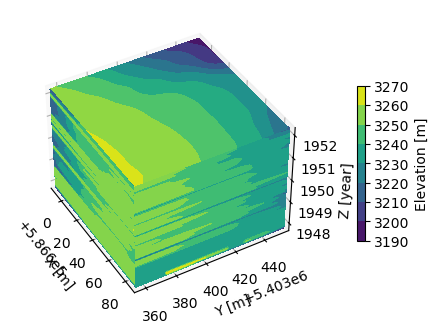

In [264]:
kw = {
    'vmin': data_toplot.min(),
    'vmax': data_toplot.max(),
    'levels': np.linspace(data_toplot.min(), data_toplot.max(), 10),
}

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')
_ = ax.contourf(
    X[:, :, -1], Y[:, :, -1], data_toplot[:, :, -1],zdir='z',offset=Z.max())
_ = ax.contourf(
    X[0, :, :],data_toplot[0, :, :],Z[0, :, :], zdir='y',offset=Y.min())
C = ax.contourf(
    data_toplot[:, -1, :], Y[:, -1, :], Z[:, -1, :],zdir='x',offset=X.max())
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [year]',
    # zticks=[0, -150, -300, -450],
)
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Elevation [m]')
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.9)
plt.show()

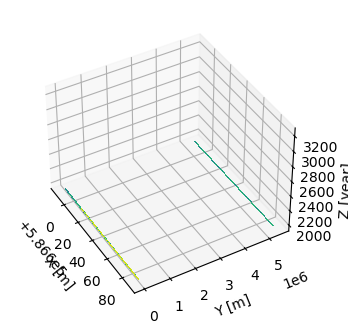

In [227]:
import matplotlib.pyplot as plt

kw = {
    'vmin': data_toplot.min(),
    'vmax': data_toplot.max(),
    'levels': np.linspace(data_toplot.min(), data_toplot.max(), 10),
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, -1], Y[:, :, -1], data_toplot[:, :, -1],zdir='z',offset=1952
)
_ = ax.contourf(
    X[0, :, :],data_toplot[0, :, :],Z[0, :, :], zdir='y',offset=360)
# C = ax.contourf(
#     data_toplot[:, -1, :], Y[:, -1, :], Z[:, -1, :],
#     zdir='y', offset=X.max(), **kw
# )
# --


# Set limits of the plot from coord limits
# xmin, xmax = X.min(), X.max()
# ymin, ymax = Y.min(), Y.max()
# zmin, zmax = Z.min(), Z.max()
# ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
# edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [year]',
    # zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.9)

# Colorbar
# fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()